In [1]:
#Importing all the neccesary libraries
import numpy as np 
import pandas as pd 
import csv

import os
print(os.listdir("input"))

import regex as re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer


# viz
import matplotlib.pyplot as plt
%matplotlib inline
import sys

# for clustering
from scipy.cluster.hierarchy import ward, dendrogram, fcluster, single, complete, average, weighted
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_score

['.ipynb_checkpoints', '951967.zip', 'Bug report 10.csv', 'Bug report 100.csv', 'Bug report.csv', 'JIRA-ALL.csv', 'JIRA.csv', 'preprocessed_data.csv']


In [2]:
data=pd.read_csv('Input/Bug report.csv')
data = data.reset_index()
data.head()

,index,Summary,Description
0,0,[DEV] Admin can add user permissions with end ...,SDET tried to test endpoint for happy case : ...
1,1,[DEV] Missing Input Validation for Endpoint Ad...,SDET tried to test endpoint for negative case ...
2,2,[STG][PP][Launcher][Recharge] There's ellipsis...,-
3,3,[DEV][AP][VersusEvil] Registered User not coun...,Registered User not count in Daily Active User...
4,4,[DEV] Fix Issues for Endpoint Admin Delete Use...,SDET tried to test endpoint DELETE /iam/v3/adm...


In [3]:
data.isnull().sum()

index          0
Summary        0
Description    0
dtype: int64

**Text data preprocessing steps**

1- Data Cleaning(either using regex or BeautifulSoup): 
a) Removing HTML characters. 
b) Removing punctuation. 
c) Decoding encoded data.
d) Split attached words.
e) Removing URLs. 
f) Apostrophe removal.
g) Removing Expressions. 
h) Uppercase & Lowercase letters 
i) Numbers such as amounts and data.

2- Data Tokenization(using word_tokenize in nltk.tokenize) 
Segregation of text into individual words i.e tokens.

3- Stopword Removal(using stopwords in nltk.corpus)
Discarding too common words or words which are not going to be helpful in our analysis.

4- Stemming(using WordNetLemmatizer in nltk.stem) 
Combining different variants of words into a single parent word that conveys same meaning.

In [4]:
stops = set(stopwords.words("english"))

In [5]:
data['Concat'] = data.Summary +" "+ data.Description
data.to_csv("./Output/data_concat.csv")

In [6]:
def clean_Description(content):
#     content = table.Description
    #Converting text to lowercase characters
    content = content.apply(lambda x: x.lower())
    #Removing HTML tags
    content = content.apply(lambda x: re.sub(r'\<[^<>]*\>','',x))
    #Removing any character which does not match to letter,digit or underscore
    content = content.apply(lambda x: re.sub(r'^\W+|\W+$',' ',x))
    #Removing space,newline,tab
    content = content.apply(lambda x: re.sub(r'\s',' ',x))
    #Removing punctuation
    content = content.apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ',x))
    #Removing numeric
    content = content.apply(lambda x: re.sub(r'[0-9]','',x))
    #Tokenizing data
    content = content.apply(lambda x: word_tokenize(x))
    #Removing stopwords
    content = content.apply(lambda x: [i for i in x if i not in stops])
    type(content)
    return(content)

In [7]:
data.Concat = clean_Description(data.Concat)

In [8]:
data.head()

,index,Summary,Description,Concat
0,0,[DEV] Admin can add user permissions with end ...,SDET tried to test endpoint for happy case : ...,"[dev, add, value, tried, test, endpoint, iam, ..."
1,1,[DEV] Missing Input Validation for Endpoint Ad...,SDET tried to test endpoint for negative case ...,"[dev, missing, input, validation, endpoint, ad..."
2,2,[STG][PP][Launcher][Recharge] There's ellipsis...,-,"[stg, pp, launcher, buy, button]"
3,3,[DEV][AP][VersusEvil] Registered User not coun...,Registered User not count in Daily Active User...,"[dev, ap, registered, login, registered, login..."
4,4,[DEV] Fix Issues for Endpoint Admin Delete Use...,SDET tried to test endpoint DELETE /iam/v3/adm...,"[dev, fix, issues, endpoint, delete, roles, tr..."


## Stemming

In [9]:
data.dtypes

index           int64
Summary        object
Description    object
Concat         object
dtype: object

In [10]:
wordnet = WordNetLemmatizer()
data.Concat = data.Concat.apply(lambda x:[wordnet.lemmatize(i,pos='v') for i in x])

# snowball = SnowballStemmer("porter")
# data.Concat = data.Concat.apply(lambda x:[snowball.stem(i) for i in x])

In [11]:
data.head()

,index,Summary,Description,Concat
0,0,[DEV] Admin can add user permissions with end ...,SDET tried to test endpoint for happy case : ...,"[dev, add, value, try, test, endpoint, iam, v,..."
1,1,[DEV] Missing Input Validation for Endpoint Ad...,SDET tried to test endpoint for negative case ...,"[dev, miss, input, validation, endpoint, add, ..."
2,2,[STG][PP][Launcher][Recharge] There's ellipsis...,-,"[stg, pp, launcher, buy, button]"
3,3,[DEV][AP][VersusEvil] Registered User not coun...,Registered User not count in Daily Active User...,"[dev, ap, register, login, register, login, pl..."
4,4,[DEV] Fix Issues for Endpoint Admin Delete Use...,SDET tried to test endpoint DELETE /iam/v3/adm...,"[dev, fix, issue, endpoint, delete, roles, try..."


In [12]:
Summary = data.Concat.astype(str)
listOfSummary = list(data.Concat)

# Hiearchical Clustering

## Jaccard Coeffient

In [13]:
import itertools
def compute_jaccard(str1, str2):
    himpunan1 = set(str1)
    himpunan2 = set(str2)
    irisan = himpunan1.intersection(himpunan2)
    gabungan = himpunan1.union(himpunan2)
    jaccard = len(irisan)/float(len(gabungan))
    
    return jaccard

In [14]:
sim_df = pd.DataFrame()

for col_pair in itertools.combinations_with_replacement(listOfSummary,2):
    strOfCol = str(col_pair)
    
    u0 = col_pair[0]
    u1 = col_pair[1]
    sim_df.loc[str(col_pair[0]), str(col_pair[1])] = compute_jaccard(u0, u1)

In [15]:
np.savetxt("./Output/distance_matrix_before_fillna.csv", np.array(sim_df), delimiter=",")

In [16]:
sim_df = sim_df.fillna(0)

In [17]:
dist = np.array(sim_df)
print(dist)

[[1.         0.44827586 0.         ... 0.07142857 0.         0.05128205]
 [0.         1.         0.         ... 0.02564103 0.         0.04081633]
 [0.         0.         1.         ... 0.11764706 0.         0.07142857]
 ...
 [0.         0.         0.         ... 1.         0.05       0.18181818]
 [0.         0.         0.         ... 0.         1.         0.14285714]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [18]:
# ndist = dist[:, ~np.isnan(dist).any(axis=0)]
# # print(ndist)

In [19]:
np.savetxt("./Output/distance_matrix.csv", dist, delimiter=",")

## Agglomerative Hierarchical Clustering

In [20]:
linkage_matrix = ward(dist) # replace with complete, single, or other scipy.cluster.hierarchical algorithms

## Visualization

Dendrogram visualization. We visualize the titles of each paper next to the corresponding leaf to qualitatively evaluate the clustering.

Changing the `color_threshold` kwarg in the call to `dendrogram()` will affect how the clusters are displayed by increasing or decreasing the 
minimum distance necessary for `dendrogram()` to color a cluster differently.

In [21]:
# sys.setrecursionlimit(10000)
# MAX_COPHENETIC_DIST = max(linkage_matrix[:,2]) * 0.39 # max distance between points to be considered together. can be tuned.
# MAX_TITLE_LEN = 200

# fig, ax = plt.subplots(figsize=(15, 80)) # set size
# ax = dendrogram(linkage_matrix, orientation="right", color_threshold=MAX_COPHENETIC_DIST, leaf_font_size=4, labels=Summary.apply(lambda x: x if len(x) < MAX_TITLE_LEN else x[:MAX_TITLE_LEN  - 3] + "...").tolist())

# plt.tick_params(axis= 'x', which='both',  bottom='off', top='off',labelbottom='off')

# plt.tight_layout() #show plot with tight layout
# plt.savefig('./Output/jaccard-coeff-ward.png', dpi=300)

# Analysis

We now take the raw clusters achieved and use the silhouette score and elbow method to evaluate.

In [22]:
def silhouette_k(distance_matrix, linkage_matrix, max_k=20):
    scores = []
    for i in range(2, max_k+1):
        clusters = fcluster(linkage_matrix, i, criterion='maxclust')
        score = silhouette_score(distance_matrix, clusters, metric='precomputed')
        print("Silhouette score with {} clusters:".format(i), score)
        scores.append(score)
    plt.title("Silhouette score vs. number of clusters")
    plt.xlabel("# of clusters")
    plt.ylabel("Score (higher is better)")
    plt.plot(np.arange(2, max_k+1), scores)
    plt.show()
    return scores
    

Silhouette score with 2 clusters: -0.4637117941260083
Silhouette score with 3 clusters: -0.69863168709219
Silhouette score with 4 clusters: -0.7490737623822706
Silhouette score with 5 clusters: -0.7708133869294024
Silhouette score with 6 clusters: -0.7713315938706189
Silhouette score with 7 clusters: -0.8155833933226798
Silhouette score with 8 clusters: -0.8216914885844304
Silhouette score with 9 clusters: -0.8689938399985903
Silhouette score with 10 clusters: -0.8687448629141388
Silhouette score with 11 clusters: -0.9669313734277906
Silhouette score with 12 clusters: -0.9696713295233745
Silhouette score with 13 clusters: -0.9689206832053037
Silhouette score with 14 clusters: -0.9679443883518732
Silhouette score with 15 clusters: -0.9669423843438572
Silhouette score with 16 clusters: -0.9659382255569364
Silhouette score with 17 clusters: -0.9650655590146313
Silhouette score with 18 clusters: -0.9643206164836156
Silhouette score with 19 clusters: -0.9664916100572245
Silhouette score wit

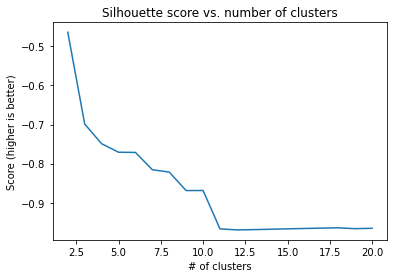

In [23]:
np.fill_diagonal(dist, 0)
_ = silhouette_k(dist, linkage_matrix)

 # Hierarchical Clustering Using Jaccard Coefficient and IDF

In [24]:
def calc_DF(tfDict):
    count_DF = {}
    # Run through each document's tf dictionary and increment countDict's (term, doc) pair
    for document in tfDict:
        for term in document:
            if term in count_DF:
                count_DF[term] += 1
            else:
                count_DF[term] = 1
    return count_DF

DF = calc_DF(listOfSummary)

In [25]:
with open('./Output/MyDFDict.csv', 'w') as f:
    for key in DF.keys():
        f.write("%s,%s\n"%(key,DF[key]))

In [26]:
n_document = len(listOfSummary)

def calc_IDF(__n_document, __DF):
    IDF_Dict = {}
    for term in __DF:
        IDF_Dict[term] = np.log(__n_document / (__DF[term] + 1))
    return IDF_Dict
  
#Stores the idf dictionary
IDF = calc_IDF(n_document, DF)

In [27]:
with open('./Output/MyIDFDict.csv', 'w') as f:
    for key in IDF.keys():
        f.write("%s,%s\n"%(key,IDF[key]))

In [28]:
def compute_jaccard(str1, str2):
    himpunan1 = set(str1)
    himpunan2 = set(str2)
    irisan = himpunan1.intersection(himpunan2)
    IDF_VAL = 0.0
    for key in irisan:
        IDF_VAL = IDF_VAL + IDF[key]
    IDF_VAL = IDF_VAL/(len(irisan)+1)
    gabungan = himpunan1.union(himpunan2)
#     jaccard = IDF_VAL
    jaccard = (len(irisan)/float(len(gabungan))) * IDF_VAL
    
    return jaccard

In [29]:
import itertools

sim_df = pd.DataFrame()

for col_pair in itertools.combinations_with_replacement(listOfSummary,2):
    strOfCol = str(col_pair)
    
    u0 = col_pair[0]
    u1 = col_pair[1]
    sim_df.loc[str(col_pair[0]), str(col_pair[1])] = compute_jaccard(u0, u1)

In [30]:
sim_df = sim_df.fillna(0)

In [31]:
dist = np.array(sim_df)

print(dist)

[[1.75127318 0.77106975 0.         ... 0.07509806 0.         0.05835601]
 [0.         2.20171352 0.         ... 0.02142709 0.         0.05434816]
 [0.         0.         1.02525515 ... 0.06104123 0.         0.04570551]
 ...
 [0.         0.         0.         ... 1.52277938 0.00725881 0.18728749]
 [0.         0.         0.         ... 0.         1.46457171 0.14903319]
 [0.         0.         0.         ... 0.         0.         1.50997598]]


In [32]:
sim_df.to_csv("./Output/jcidf_matrix.csv")

## Agglomerative Hierarchical Clustering

In [33]:
linkage_matrix = ward(dist) # replace with complete, single, or other scipy.cluster.hierarchical algorithms

## Visualization

Dendrogram visualization. We visualize the titles of each paper next to the corresponding leaf to qualitatively evaluate the clustering.

Changing the `color_threshold` kwarg in the call to `dendrogram()` will affect how the clusters are displayed by increasing or decreasing the 
minimum distance necessary for `dendrogram()` to color a cluster differently.

In [34]:
# sys.setrecursionlimit(10000)
# MAX_COPHENETIC_DIST = max(linkage_matrix[:,2]) * 0.39 # max distance between points to be considered together. can be tuned.
# MAX_TITLE_LEN = 200

# fig, ax = plt.subplots(figsize=(15, 80)) # set size
# ax = dendrogram(linkage_matrix, orientation="right", color_threshold=MAX_COPHENETIC_DIST, leaf_font_size=4,
#                 labels=Summary.apply(lambda x: x if len(x) < MAX_TITLE_LEN else x[:MAX_TITLE_LEN  - 3] + "...").tolist())

# plt.tick_params(axis= 'x', which='both',  bottom='off', top='off',labelbottom='off')

# plt.tight_layout() #show plot with tight layout
# plt.savefig('./Output/jaccard-idf-coeff-ward.png', dpi=300)

# Analysis

We now take the raw clusters achieved and use the silhouette score and elbow method to evaluate.

In [35]:
def silhouette_k(distance_matrix, linkage_matrix, max_k=20):
    scores = []
    for i in range(2, max_k+1):
        clusters = fcluster(linkage_matrix, i, criterion='maxclust')
        score = silhouette_score(distance_matrix, clusters, metric='precomputed')
        print("Silhouette score with {} clusters:".format(i), score)
        scores.append(score)
    plt.title("Silhouette score vs. number of clusters")
    plt.xlabel("# of clusters")
    plt.ylabel("Score (higher is better)")
    plt.plot(np.arange(2, max_k+1), scores)
    plt.show()
    return scores

Silhouette score with 2 clusters: -0.6002705955310467
Silhouette score with 3 clusters: -0.6345542440983843
Silhouette score with 4 clusters: -0.6714700827096836
Silhouette score with 5 clusters: -0.7516657669652884
Silhouette score with 6 clusters: -0.7919538628729238
Silhouette score with 7 clusters: -0.8515845896783548
Silhouette score with 8 clusters: -0.8633669675292565
Silhouette score with 9 clusters: -0.8627323212371145
Silhouette score with 10 clusters: -0.8854231520121508
Silhouette score with 11 clusters: -0.8852082607021298
Silhouette score with 12 clusters: -0.9094055207489654
Silhouette score with 13 clusters: -0.909103303799218
Silhouette score with 14 clusters: -0.9810204296786283
Silhouette score with 15 clusters: -0.9809281236704115
Silhouette score with 16 clusters: -0.97999471010308
Silhouette score with 17 clusters: -0.979101357186124
Silhouette score with 18 clusters: -0.9787659445889832
Silhouette score with 19 clusters: -0.9777639405809673
Silhouette score with 

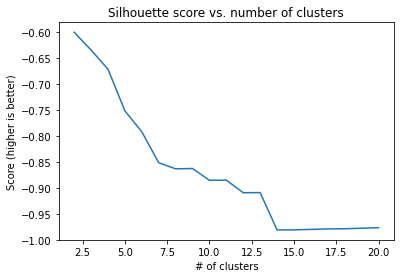

In [36]:
np.fill_diagonal(dist, 0)
_ = silhouette_k(dist, linkage_matrix)